## `MEMORANDO INTERNO - Streaming`

PARA: Equipe de Ciência de Dados e Back-end - Setor de Retenção

DE: Diretor de Operações da Streming

DATA: 15 de Maio de 2024

ASSUNTO: Crise de Cancelamentos - Prioridade Máxima


## `NOSSA SITUAÇÃO ATUAL`

"Prezados,

Somos a Streaming, uma plataforma de streaming 100% brasileira focada em produções nacionais e esportes locais. Crescemos muito na pandemia, mas nos últimos meses, nossa taxa de cancelamento (Churn) disparou.

Não sabemos exatamente o porquê. Alguns dizem que é o preço, outros dizem que é o app travando em TVs antigas, ou a falta de conteúdo infantil.

Extraímos um dump do nosso banco de dados legado com 30.000 clientes. Atenção: Essa extração vem de sistemas diferentes (CRM, Billing e App de Analytics), então os dados não estão perfeitos, mas estamos enviando um Dicionario deles.

O desafio de vocês é limpar os dados, descobrir quem vai cancelar, gerar insights e nos entregar uma API para que nosso time  possa desenvolver estratégia antes que o cliente clique em 'Cancelar Assinatura'."


`Atenciosamente:`

Diretor de Operações

Streaming

## `Dicionário de Dados`

| Coluna | Descrição |
| :--- | :--- |
| **`cliente_id`** | Número de identificação único de cada cliente. |
| **`churn`** | **TARGET (Variável Alvo):** Indica se o cliente cancelou (1) ou está ativo (0). |
| **`idade`** | Idade do cliente. |
| **`genero`** | Gênero do cliente. |
| **`regiao`** | Região geográfica do Brasil do cliente. |
| **`tipo_contrato`** | Modalidade de cobrança do cliente: Mensal ou Anual. |
| **`metodo_pagamento`** | Forma como o cliente paga a assinatura. |
| **`plano_assinatura`** | Qual plano o cliente possui: Básico, Padrão ou Premium. |
| **`valor_mensal`** | Valor da Mensalidade. |
| **`tempo_assinatura_meses`** | Tempo em meses em que o cliente é assinante. |
| **`dias_ultimo_acesso`** | Número de dias desde o último acesso à plataforma. |
| **`acessibilidade`** | Se o cliente usou algum recurso de acessibilidade (0=Não, 1=Sim). |
| **`contatos_suporte`** | Quantidade total de contatos feitos com o suporte. |
| **`visualizacoes_mes`** | Total de conteúdo visualizado no último mês. |
| **`tempo_medio_sessao_min`** | Tempo médio de cada sessão de visualização em minutos. |
| **`dispositivo_principal`** | Dispositivo mais utilizado para visualizar o conteúdo. |
| **`categoria_favorita`** | Formato de conteúdo mais assistido. |
| **`avaliacao_conteudo_media`** | Média de avaliação de conteúdo durante todo o período do contrato. Se vazio cliente nao avaliou |
| **`avaliacao_conteudo_ultimo_mes`** | Avaliação média do conteúdo no último mês de assinatura. Se vazio cliente nao avaliou |
| **`avaliacao_plataforma`** | Avaliação média da plataforma pelo cliente. Se vazio cliente nao avaliou |

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/rafaelreisramos/oracle-one-g8-hackathon/refs/heads/main/data/dados_streamingV4.csv')

In [ ]:
df.head()

,cliente_id,idade,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,acessibilidade,contatos_suporte,visualizacoes_mes,tempo_medio_sessao_min,dispositivo_principal,categoria_favorita,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma,churn
0,CLI_000001,44,Feminino,Sudeste,Mensal,Pix,Padrão,38.0,42,27,0,2,15,169,Mobile,Séries,5.0,3.0,2.0,0
1,CLI_000002,36,Feminino,Sudeste,Mensal,Crédito Recorrente,Premium,49.9,20,23,0,1,15,97,Mobile,Filmes,2.0,NaN,3.0,0
2,CLI_000003,46,Feminino,Sudeste,Mensal,Cartão de Crédito,Básico,24.9,6,14,0,2,56,118,Desktop,Séries,1.5,NaN,NaN,0
3,CLI_000004,57,Masculino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,10,70,0,0,0,31,TV,Séries,4.0,NaN,NaN,1
4,CLI_000005,34,Outros,Nordeste,Mensal,Crédito Recorrente,Premium,49.9,22,31,0,1,0,46,Mobile,Esportes,4.0,NaN,1.5,0


In [ ]:
df.tail(10)

,cliente_id,idade,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,acessibilidade,contatos_suporte,visualizacoes_mes,tempo_medio_sessao_min,dispositivo_principal,categoria_favorita,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma,churn
29990,CLI_029991,35,Masculino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,31,19,0,0,85,65,mobile,Séries,"4,0","4,5","3,0",0
29991,CLI_029992,61,Masculino,Nordeste,Mensal,Pix,Básico,24.9,8,13,0,2,20,18,TV,Séries,"2,0","2,5",NaN,1
29992,CLI_029993,49,NaN,Centro-Oeste,Anual,Crédito Recorrente,Premium,38.0,15,15,0,1,51,82,tv,Infantil,NaN,"4,0","3,5",0
29993,CLI_029994,21,Masculino,Centro-Oeste,Anual,Crédito Recorrente,Premium,38.0,6,21,0,1,14,90,Mobile,Séries,"4,0",NaN,"4,0",0
29994,CLI_029995,21,Masculino,Sudeste,Mensal,Pix,Básico,24.9,29,34,1,2,0,106,TV,Documentários,NaN,NaN,"1,0",0
29995,CLI_029996,30,Feminino,Nordeste,Anual,Crédito Recorrente,Padrão,32.0,0,1,0,2,87,121,Desktop,Filmes,NaN,"3,5","2,0",0
29996,CLI_029997,56,Feminino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,0,0,0,1,71,76,tv,Séries,NaN,"3,5",NaN,0
29997,CLI_029998,31,Feminino,Nordeste,Anual,Crédito Recorrente,Premium,38.0,0,1,0,5,80,29,Tablet,Infantil,NaN,"3,5","4,5",0
29998,CLI_029999,18,Masculino,Sudeste,Anual,Crédito Recorrente,Premium,38.0,9,29,0,3,11,135,mobile,Séries,"4,0","4,0","4,5",0
29999,CLI_030000,35,Feminino,Sul,Anual,Crédito Recorrente,Premium,38.0,24,24,0,0,6,88,Mobile,Documentários,NaN,NaN,"3,0",0


In [ ]:
# ---------------------------------------------------
# 1. Dimensões do dataset
# ---------------------------------------------------
print(f'Linhas: {df.shape[0]}')
print(f'Colunas: {df.shape[1]}')

Linhas: 30000
Colunas: 20


In [ ]:
# ---------------------------------------------------
# 2. Informações do dataset
# ---------------------------------------------------
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cliente_id                     30000 non-null  object 
 1   idade                          30000 non-null  int64  
 2   genero                         27000 non-null  object 
 3   regiao                         30000 non-null  object 
 4   tipo_contrato                  30000 non-null  object 
 5   metodo_pagamento               30000 non-null  object 
 6   plano_assinatura               30000 non-null  object 
 7   valor_mensal                   30000 non-null  float64
 8   tempo_assinatura_meses         30000 non-null  int64  
 9   dias_ultimo_acesso             30000 non-null  int64  
 10  acessibilidade                 30000 non-null  int64  
 11  contatos_suporte               30000 non-null  int64  
 12  visualizacoes_mes              30000 non-null 

In [ ]:
for col in ['avaliacao_conteudo_media', 'avaliacao_conteudo_ultimo_mes','avaliacao_plataforma']:
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# ---------------------------------------------------
# 3. Verificação de valores ausentes
# ---------------------------------------------------
df.isnull().sum().sort_values(ascending=False)

,0
avaliacao_conteudo_ultimo_mes,17597
avaliacao_conteudo_media,11777
avaliacao_plataforma,6041
genero,3000
regiao,0
idade,0
cliente_id,0
tipo_contrato,0
tempo_assinatura_meses,0
metodo_pagamento,0


In [ ]:
df['genero'] = df['genero'].fillna('Não Informar')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cliente_id                     30000 non-null  object 
 1   idade                          30000 non-null  int64  
 2   genero                         30000 non-null  object 
 3   regiao                         30000 non-null  object 
 4   tipo_contrato                  30000 non-null  object 
 5   metodo_pagamento               30000 non-null  object 
 6   plano_assinatura               30000 non-null  object 
 7   valor_mensal                   30000 non-null  float64
 8   tempo_assinatura_meses         30000 non-null  int64  
 9   dias_ultimo_acesso             30000 non-null  int64  
 10  acessibilidade                 30000 non-null  int64  
 11  contatos_suporte               30000 non-null  int64  
 12  visualizacoes_mes              30000 non-null 

In [ ]:
# ---------------------------------------------------
# 4. Resumo estatístico (somente numéricas)
# ---------------------------------------------------
df.describe()

,idade,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,acessibilidade,contatos_suporte,visualizacoes_mes,tempo_medio_sessao_min,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma,churn
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0000,30000.000000,30000.000000,18223.000000,12403.000000,23959.000000,30000.000000
mean,37.870033,32.248543,13.058233,24.850167,0.051567,1.1996,27.978700,73.533933,3.353893,3.669112,2.992571,0.249067
std,12.240975,7.818732,12.388886,17.957359,0.221154,1.0973,31.946358,44.548880,1.041406,1.055451,1.288870,0.432480
min,18.000000,22.000000,0.000000,0.000000,0.000000,0.0000,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000
25%,29.000000,24.900000,3.000000,12.000000,0.000000,0.0000,0.000000,35.000000,2.000000,3.000000,2.000000,0.000000
50%,38.000000,32.000000,9.000000,22.000000,0.000000,1.0000,13.000000,73.000000,4.000000,4.000000,3.000000,0.000000
75%,46.000000,38.000000,19.000000,34.000000,0.000000,2.0000,54.000000,106.000000,4.000000,4.500000,4.000000,0.000000
max,85.000000,49.900000,48.000000,112.000000,1.000000,7.0000,159.000000,249.000000,5.000000,5.000000,5.000000,1.000000


In [ ]:
# ---------------------------------------------------
# 5. Resumo estatístico para variáveis categóricas
# ---------------------------------------------------
df.describe(include = 'object')

,cliente_id,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,dispositivo_principal,categoria_favorita
count,30000,30000,30000,30000,30000,30000,30000,30000
unique,30000,4,5,2,6,3,6,6
top,CLI_029984,Feminino,Sudeste,Mensal,Crédito Recorrente,Básico,Tablet,Séries
freq,1,12169,13475,21574,15872,13771,5054,9030


In [ ]:
# ---------------------------------------------------
# 6. Distribuição da variável target (Churn)
# ---------------------------------------------------
df['churn'].value_counts(normalize = True)

,proportion
churn,
0,0.750933
1,0.249067


In [ ]:
# ---------------------------------------------------
# 7. Colunas dataset
# ---------------------------------------------------
list(df.columns)

['cliente_id',
 'idade',
 'genero',
 'regiao',
 'tipo_contrato',
 'metodo_pagamento',
 'plano_assinatura',
 'valor_mensal',
 'tempo_assinatura_meses',
 'dias_ultimo_acesso',
 'acessibilidade',
 'contatos_suporte',
 'visualizacoes_mes',
 'tempo_medio_sessao_min',
 'dispositivo_principal',
 'categoria_favorita',
 'avaliacao_conteudo_media',
 'avaliacao_conteudo_ultimo_mes',
 'avaliacao_plataforma',
 'churn']

In [ ]:
# ---------------------------------------------------
# 8. Correções no nomes de algumas variaveis
# ---------------------------------------------------
substituicoes = {'mobile': 'Mobile', 'tv': 'TV'}
df.replace(substituicoes, inplace=True)

grupos = ('genero', 'regiao', 'tipo_contrato', 'metodo_pagamento', 'plano_assinatura', 'dispositivo_principal', 'categoria_favorita', 'churn')
for grupo in grupos:
    print(f'{df.groupby(grupo).size()}')
    print(15 * '_')
    print('\n')

genero
Feminino        12169
Masculino       12148
Não Informar     5159
Outros            524
dtype: int64
_______________


regiao
Centro-Oeste     3000
Nordeste         6026
Norte            1466
Sudeste         13475
Sul              6033
dtype: int64
_______________


tipo_contrato
Anual      8426
Mensal    21574
dtype: int64
_______________


metodo_pagamento
Boleto                 1088
Cartão de Crédito      5413
Crédito Recorrente    15872
Débito                 3342
Débito Automático      1715
Pix                    2570
dtype: int64
_______________


plano_assinatura
Básico     13771
Padrão      9027
Premium     7202
dtype: int64
_______________


dispositivo_principal
Desktop     4980
Mobile     10024
TV          9942
Tablet      5054
dtype: int64
_______________


categoria_favorita
Documentários    4552
Esportes         4442
Filmes           7464
Infantil         3032
Novelas          1480
Séries           9030
dtype: int64
_______________


churn
0    22528
1     7472
dty

In [ ]:
# ---------------------------------------------------
# 8. Distribuição de algumas variaveis
# ---------------------------------------------------
grupo = ('regiao', 'tipo_contrato', 'plano_assinatura', 'metodo_pagamento', 'acessibilidade', 'contatos_suporte',
        'dispositivo_principal', 'categoria_favorita', 'genero', 'avaliacao_plataforma', 'avaliacao_conteudo_media',
         'avaliacao_conteudo_ultimo_mes')

for i in grupo:
    print(f'{df.groupby(i).size().sort_values(ascending=False)}')
    print(15 * '_')
    print('\n')

regiao
Sudeste         13475
Sul              6033
Nordeste         6026
Centro-Oeste     3000
Norte            1466
dtype: int64
_______________


tipo_contrato
Mensal    21574
Anual      8426
dtype: int64
_______________


plano_assinatura
Básico     13771
Padrão      9027
Premium     7202
dtype: int64
_______________


metodo_pagamento
Crédito Recorrente    15872
Cartão de Crédito      5413
Débito                 3342
Pix                    2570
Débito Automático      1715
Boleto                 1088
dtype: int64
_______________


acessibilidade
0    28453
1     1547
dtype: int64
_______________


contatos_suporte
1    10926
0     9000
2     6508
3     2536
4      782
5      192
6       42
7       14
dtype: int64
_______________


dispositivo_principal
Mobile     10024
TV          9942
Tablet      5054
Desktop     4980
dtype: int64
_______________


categoria_favorita
Séries           9030
Filmes           7464
Documentários    4552
Esportes         4442
Infantil         3032
Novela

In [ ]:
# ---------------------------------------------------
# 9. Distribuição de algumas variaveis por % de churn
# ---------------------------------------------------
grupo = ('regiao', 'tipo_contrato', 'plano_assinatura', 'metodo_pagamento', 'acessibilidade', 'contatos_suporte',
        'dispositivo_principal', 'categoria_favorita', 'genero', 'avaliacao_plataforma', 'avaliacao_conteudo_media')

for i in grupo:
    print(f'{df.groupby(i)['churn'].value_counts(normalize = True)}')
    print(15 * '_')
    print('\n')

regiao        churn
Centro-Oeste  0        0.751333
              1        0.248667
Nordeste      0        0.745934
              1        0.254066
Norte         0        0.772851
              1        0.227149
Sudeste       0        0.751391
              1        0.248609
Sul           0        0.749378
              1        0.250622
Name: proportion, dtype: float64
_______________


tipo_contrato  churn
Anual          0        0.868384
               1        0.131616
Mensal         0        0.705062
               1        0.294938
Name: proportion, dtype: float64
_______________


plano_assinatura  churn
Básico            0        0.708954
                  1        0.291046
Padrão            0        0.736457
                  1        0.263543
Premium           0        0.849347
                  1        0.150653
Name: proportion, dtype: float64
_______________


metodo_pagamento    churn
Boleto              0        0.528493
                    1        0.471507
Cartão de Cr

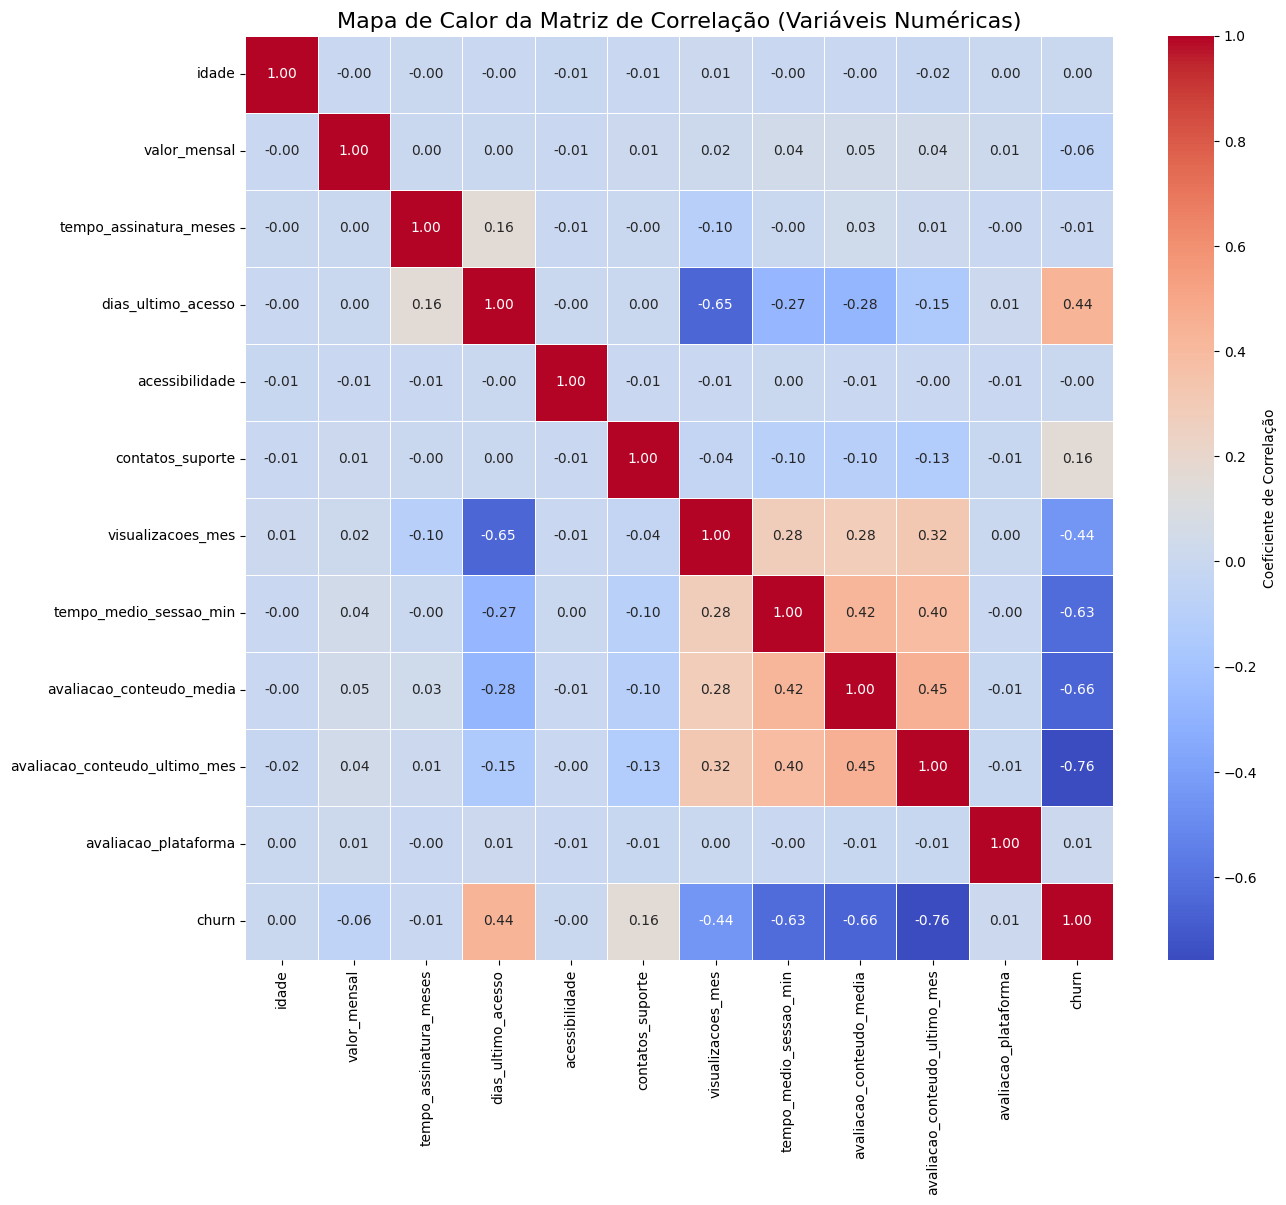

In [ ]:
# ---------------------------------------------------
# 10. Verificação grafica do corr do com chunr
# ---------------------------------------------------

df_corr = df.copy()

df_numerico = df_corr.select_dtypes(include=['number'])

if 'cliente_id' in df_numerico.columns:
    df_numerico = df_numerico.drop(columns=['cliente_id'])

matriz_correlacao = df_numerico.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(matriz_correlacao,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=.5,
            cbar_kws={'label': 'Coeficiente de Correlação'})

plt.title('Mapa de Calor da Matriz de Correlação (Variáveis Numéricas)', fontsize=16)
plt.show()

In [ ]:
# ---------------------------------------------------
# 9. Verificação tabular do corr do com chunr
# ---------------------------------------------------
print("--- Correlação com Churn ---")
correlacao = df.select_dtypes(include=['number']).corr()['churn'].sort_values(ascending=False)
print(correlacao)
print("\n")


--- Correlação com Churn ---
churn                            1.000000
dias_ultimo_acesso               0.435945
contatos_suporte                 0.158369
avaliacao_plataforma             0.011481
idade                            0.003011
acessibilidade                  -0.001849
tempo_assinatura_meses          -0.008157
valor_mensal                    -0.062376
visualizacoes_mes               -0.441336
tempo_medio_sessao_min          -0.627054
avaliacao_conteudo_media        -0.659018
avaliacao_conteudo_ultimo_mes   -0.756981
Name: churn, dtype: float64




In [ ]:
#df['fez_avaliacao_conteudo'] = np.where(df['avaliacao_conteudo_media'].isna(), 0, 1)
#df['fez_avaliacao_plataforma'] = np.where(df['avaliacao_plataforma'].isna(), 0, 1)
#df['fez_avaliacao_ultimo_mes'] = np.where(df['avaliacao_conteudo_ultimo_mes'].isna(), 0, 1)
#df.info()

In [ ]:
# ---------------------------------------------------
# 3. Verificação de valores ausentes
# ---------------------------------------------------
df.isnull().sum().sort_values(ascending=False)

,0
avaliacao_conteudo_ultimo_mes,17597
avaliacao_conteudo_media,11777
avaliacao_plataforma,6041
cliente_id,0
regiao,0
genero,0
idade,0
tipo_contrato,0
tempo_assinatura_meses,0
metodo_pagamento,0


In [ ]:
# ---------------------------------------------------
# 3. Inserção de dados faltantes
# - Definie as colunas a serem preenchidas
# - Exclui a coluna `cliente_id` e `churn` (variável alvo) dos preditores
# - Identifica colunas numéricas e categóricas
# - Faz o One Hot Encoding das colunas categóricas
# - Configura e aplica o pipeline do KNNImputer
# - Reconstroi as colunas categoricas
# - Substitui as colunas preenchidas no dataset original
# - Exibe uma pequena estatística do preenchimento
# ---------------------------------------------------

df_original = df.copy()

cols_to_impute = ['avaliacao_conteudo_ultimo_mes', 'avaliacao_conteudo_media', 'avaliacao_plataforma']
cols_to_exclude = ['cliente_id', 'churn']
cols_to_use = [col for col in df.columns if col not in cols_to_exclude]

df_impute = df[cols_to_use].copy()

numerical_cols = df_impute.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_impute.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer(n_neighbors=5))
])
df_imputed_array = knn_pipeline.fit_transform(df_impute)

feature_names_out = knn_pipeline['preprocessor'].get_feature_names_out()
df_imputed_processed = pd.DataFrame(df_imputed_array, columns=feature_names_out)

original_numerical_order = [col for col in numerical_cols if col in df_impute.columns]
all_feature_names = list(feature_names_out)
imputed_values = df_imputed_array[:, [all_feature_names.index(f'remainder__{col}') for col in cols_to_impute]]

imputed_df_cols = [f'remainder__{col}' for col in cols_to_impute]
imputed_data_for_target_cols = df_imputed_processed[imputed_df_cols]
for i, col in enumerate(cols_to_impute):
    df_original[col] = imputed_data_for_target_cols.iloc[:, i].values

print("### 📊 Estatísticas de Valores Ausentes (NaNs) ###")
for col in cols_to_impute:
    nans_before = df[col].isnull().sum()
    nans_after = df_original[col].isnull().sum()
    print(f"**{col}**:")
    print(f"  - NaNs Antes da Imputação: {nans_before}")
    print(f"  - NaNs Depois da Imputação: {nans_after}")

print("\n### 📋 Amostra do DataFrame após Imputação (Colunas de Avaliação) ###")
print(df_original[['avaliacao_conteudo_media', 'avaliacao_conteudo_ultimo_mes', 'avaliacao_plataforma']].head())

### 📊 Estatísticas de Valores Ausentes (NaNs) ###
**avaliacao_conteudo_ultimo_mes**:
  - NaNs Antes da Imputação: 17597
  - NaNs Depois da Imputação: 0
**avaliacao_conteudo_media**:
  - NaNs Antes da Imputação: 11777
  - NaNs Depois da Imputação: 0
**avaliacao_plataforma**:
  - NaNs Antes da Imputação: 6041
  - NaNs Depois da Imputação: 0

### 📋 Amostra do DataFrame após Imputação (Colunas de Avaliação) ###
   avaliacao_conteudo_media  avaliacao_conteudo_ultimo_mes  \
0                       5.0                            3.0   
1                       2.0                            4.2   
2                       1.5                            3.8   
3                       4.0                            2.3   
4                       4.0                            2.2   

   avaliacao_plataforma  
0                   2.0  
1                   3.0  
2                   2.5  
3                   3.3  
4                   1.5  


#  Definição da base final para o modelo

In [ ]:
# OBS:
# A partir deste ponto, usamos o df_original como base (df_model).
# Ele já traz todo o pré-processamento aplicado ao dataset bruto:
# - ajustes de tipos e tratamentos iniciais dos dados;
# - preenchimento dos valores faltantes nas colunas de avaliação
#   (avaliacao_conteudo_media, avaliacao_conteudo_ultimo_mes,
#    avaliacao_plataforma) com KNNImputer;
# - garantia de que as demais colunas estejam consistentes e sem NaNs.
#
# Assim, o modelo de Regressão Logística é treinado em um conjunto
# de dados já limpo e completo, reduzindo erros e possíveis vieses
# causados por valores ausentes.

# - df_original:
df_model = df_original.copy()


In [ ]:

# 2. Seleção de features (X) e alvo (y)

# Alvo: coluna binária de churn
y = df_model['churn']

# Features numéricas
cols_num = [
    'idade', 'valor_mensal', 'tempo_assinatura_meses',
    'dias_ultimo_acesso', 'contatos_suporte',
    'visualizacoes_mes', 'tempo_medio_sessao_min',
    'avaliacao_conteudo_media', 'avaliacao_conteudo_ultimo_mes',
    'avaliacao_plataforma'
]

# Features categóricas
cols_cat = [
    'genero', 'regiao', 'tipo_contrato', 'metodo_pagamento',
    'plano_assinatura', 'acessibilidade',
    'dispositivo_principal', 'categoria_favorita'
]

# DataFrame final de entrada do modelo
X = df_model[cols_num + cols_cat]


# Treinamento Split/teste

In [ ]:

# 3. Split dos dados em treino e teste

# from sklearn.model_selection import train_test_split

# Separação em treino (80%) e teste (20%)
# stratify=y garante que a proporção de churn 0/1
# fique parecida em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Tamanho X_train:", X_train.shape)
print("Tamanho X_test :", X_test.shape)
print("Tamanho y_train:", y_train.shape)
print("Tamanho y_test :", y_test.shape)


Tamanho X_train: (24000, 18)
Tamanho X_test : (6000, 18)
Tamanho y_train: (24000,)
Tamanho y_test : (6000,)


# Pipeline + Regressão Logística

In [ ]:

# 4. Pipeline de pré-processamento + modelo


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Mesmas listas usadas para montar X
cols_num = [
    'idade', 'valor_mensal', 'tempo_assinatura_meses',
    'dias_ultimo_acesso', 'contatos_suporte',
    'visualizacoes_mes', 'tempo_medio_sessao_min',
    'avaliacao_conteudo_media', 'avaliacao_conteudo_ultimo_mes',
    'avaliacao_plataforma'
]

cols_cat = [
    'genero', 'regiao', 'tipo_contrato', 'metodo_pagamento',
    'plano_assinatura', 'acessibilidade',
    'dispositivo_principal', 'categoria_favorita'
]

# 4.1 Pré-processamento: escala nas numéricas + one-hot nas categóricas
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cols_cat)
    ]
)

# 4.2 Pipeline final: pré-processamento + Regressão Logística
clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])


# Treino / avaliação do modelo

In [ ]:

# 5. Treino e avaliação do modelo

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Acurácia: 0.9618333333333333
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4506
           1       0.91      0.94      0.92      1494

    accuracy                           0.96      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.96      0.96      0.96      6000



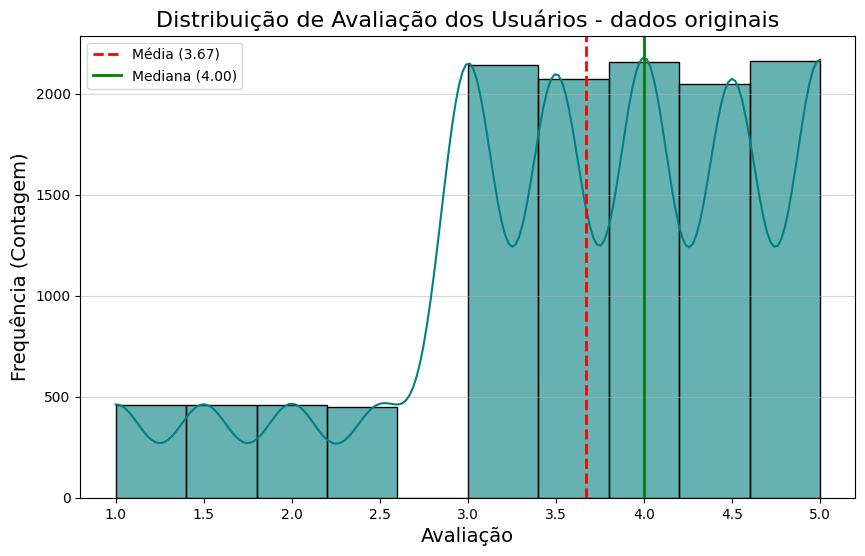

In [ ]:
def plot_histogram(df, column, title):
    plt.figure(figsize=(10, 6))

    sns.histplot(
        df[column],
        bins=10,
        kde=True,
        color='teal',
        edgecolor='black',
        alpha=0.6,
        stat="count"
    )

    media = df[column].mean()
    plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Média ({media:.2f})')
    mediana = df[column].median()
    plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana ({mediana:.2f})')

    plt.title(title, fontsize=16)
    plt.xlabel('Avaliação', fontsize=14)
    plt.ylabel('Frequência (Contagem)', fontsize=14)
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show()

df_avaliacao_conteudo_ultimo_mes_limpo = df.dropna(subset=['avaliacao_conteudo_ultimo_mes'])
plot_histogram(df_avaliacao_conteudo_ultimo_mes_limpo, 'avaliacao_conteudo_ultimo_mes', 'Distribuição de Avaliação dos Usuários - dados originais')

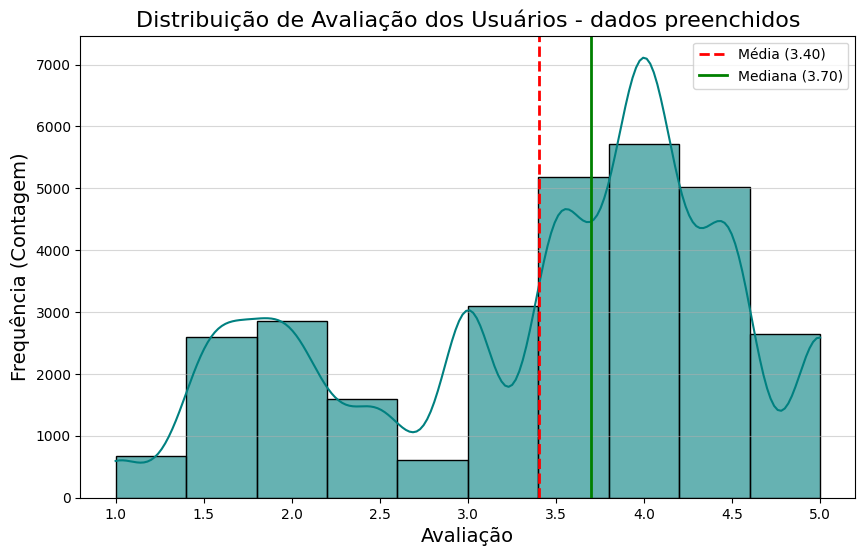

In [ ]:
df_avaliacao_conteudo_ultimo_mes_limpo = df_original.dropna(subset=['avaliacao_conteudo_ultimo_mes'])
plot_histogram(df_avaliacao_conteudo_ultimo_mes_limpo, 'avaliacao_conteudo_ultimo_mes', 'Distribuição de Avaliação dos Usuários - dados preenchidos')

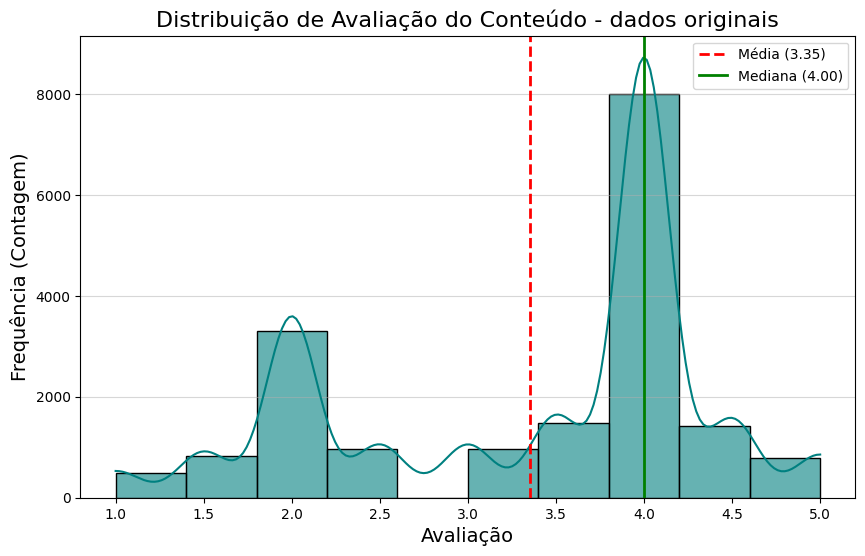

In [ ]:
df_avaliacao_conteudo_media_limpo = df.dropna(subset=['avaliacao_conteudo_media'])
plot_histogram(df_avaliacao_conteudo_media_limpo, 'avaliacao_conteudo_media', 'Distribuição de Avaliação do Conteúdo - dados originais')

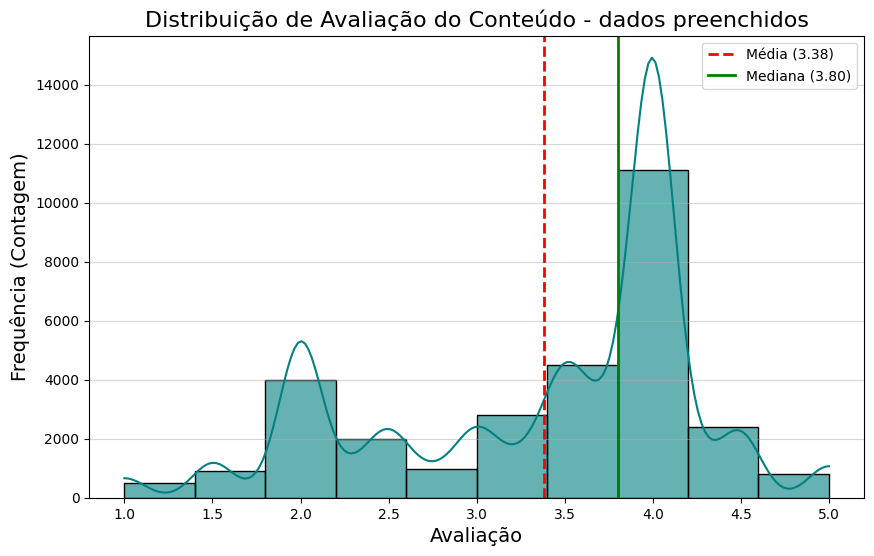

In [ ]:
df_avaliacao_conteudo_media_limpo = df_original.dropna(subset=['avaliacao_conteudo_media'])
plot_histogram(df_avaliacao_conteudo_media_limpo, 'avaliacao_conteudo_media', 'Distribuição de Avaliação do Conteúdo - dados preenchidos')

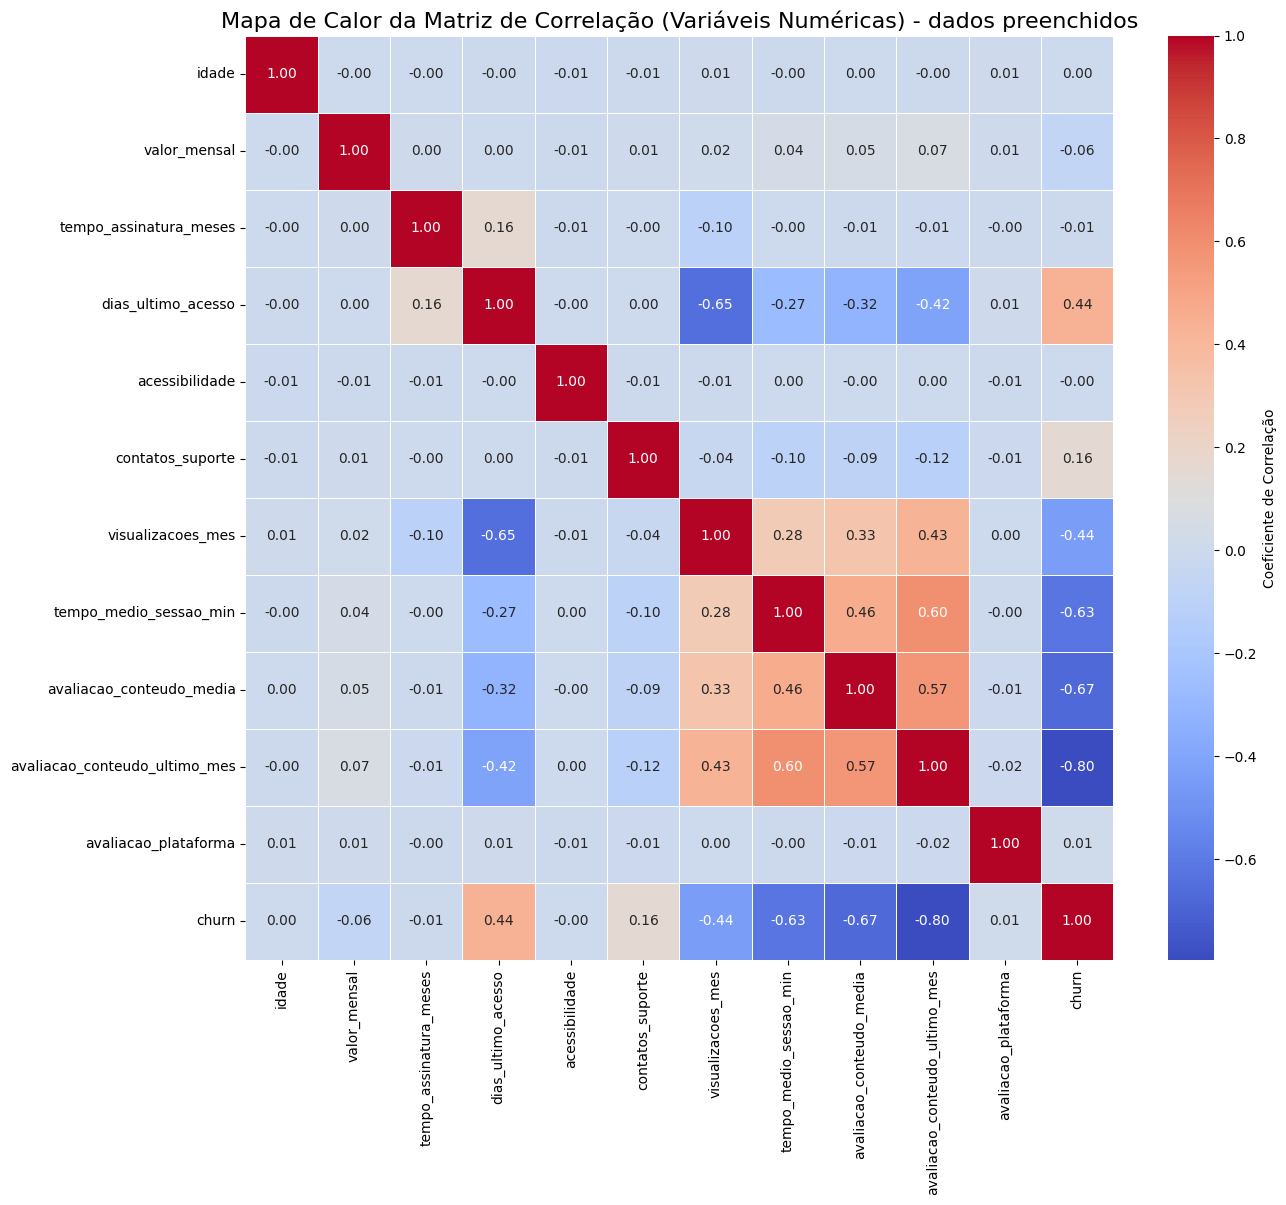

In [ ]:
# ---------------------------------------------------
# 10. Verificação grafica do corr do com chunr
# ---------------------------------------------------

df_corr = df_original.copy()

df_numerico = df_corr.select_dtypes(include=['number'])

if 'cliente_id' in df_numerico.columns:
    df_numerico = df_numerico.drop(columns=['cliente_id'])

matriz_correlacao = df_numerico.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(matriz_correlacao,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=.5,
            cbar_kws={'label': 'Coeficiente de Correlação'})

plt.title('Mapa de Calor da Matriz de Correlação (Variáveis Numéricas) - dados preenchidos', fontsize=16)
plt.show()